# Exercise 19 - Approximate Inference with PyMC

In someone's garden they have a sprinkler that waters that grass when the weather is dry. 

* The sprinkler is less likely to turn on when it rains
* The grass gets wet when it rains or when the sprinker is on.

Given variables $W$ (grass is wet), $S$ (sprinkler is on), and $R$ (it is raining) we can construct the following Bayesian network)

$P(S,R,W) = P(W\vert R,S)P(S\vert R)P(R)$

The conditional probabilities are:

* $P(R) = 0.6$, $P(\lnot R) = 0.4$
* $P(S\vert R) = 0.05$, $P(\lnot S\vert R) = 0.95$, $P(S\vert \lnot R) = 0.8$, $P(\lnot S\vert \lnot R) = 0.2$
* $P(W\vert S,R)=0.95$, $P(\lnot W\vert S,R)=0.05$, $P(W\vert S,\lnot R)=0.3$, $P(\lnot W\vert S,\lnot R)=0.7$, $P(W\vert \lnot S,R)=0.75$, $P(\lnot W\vert \lnot S,R)=0.25$, $P(W\vert \lnot S,\lnot R)=0.35$, $P(\lnot W\vert \lnot S,\lnot R)=0.65$

* $P(W\vert S\land R) = 0.95$, $P(\lnot W\vert S\land R) = 0.05$
* $P(W\vert S\land \lnot R) = 0.70$, $P(\lnot W\vert S\land \lnot R) = 0.30$
* $P(W\vert \lnot S\land R) = 0.80$, $P(\lnot W\vert \lnot S\land R) = 0.20$
* $P(W\vert \lnot S\land \lnot R) = 0.01$, $P(\lnot W\vert \lnot S\land \lnot R) = 0.99$

Use discrete sampling and rejection sampling to compute the following quantities. Verify your answers by explicit calculation.

1. $P(W)$
2. $P(R\vert W$)
3. $P(S\vert W$)




## Solutions

We have already solved this problem using standard MC; let's now do this using PyMC. As a reminder, here is how we defined the conditional distributions for standard MC

In [1]:
import numpy as np
P_R = np.array([0.4,0.6])
P_S_R = np.array([[0.2,0.8],[0.95,0.05]])
P_W_SR = np.array([
    [[0.99,0.01],[0.2,0.8]],
    [[0.3,0.7],[0.05,0.95]]
]) # P_W_SR[is,ir,iw]


In PyMC, this is how we would do this. Notice how we implement $P(W\vert S,R)$ using nested `switch` statements.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Rain]
>Metropolis: [Sprinkler]
>Metropolis: [GrassIsWet]


Output()

Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 19 seconds.


array([[<Axes: title={'center': 'Rain'}>,
        <Axes: title={'center': 'Rain'}>],
       [<Axes: title={'center': 'Sprinkler'}>,
        <Axes: title={'center': 'Sprinkler'}>],
       [<Axes: title={'center': 'GrassIsWet'}>,
        <Axes: title={'center': 'GrassIsWet'}>],
       [<Axes: title={'center': 'P_Sprinkler'}>,
        <Axes: title={'center': 'P_Sprinkler'}>],
       [<Axes: title={'center': 'P_GrassIsWet'}>,
        <Axes: title={'center': 'P_GrassIsWet'}>]], dtype=object)

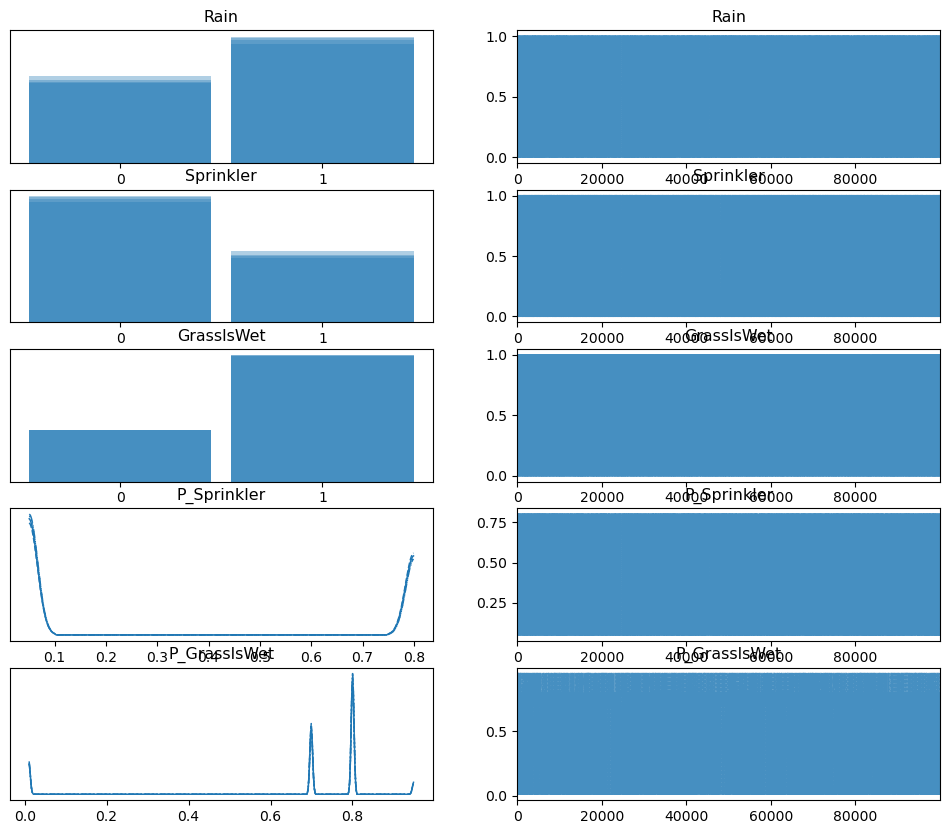

In [2]:
import pymc as mc
with mc.Model() as model:
    Rain = mc.Bernoulli('Rain',0.6)
    P_Sprinkler = mc.Deterministic('P_Sprinkler', mc.math.switch(Rain,0.05,0.8))
    Sprinkler = mc.Bernoulli('Sprinkler',P_Sprinkler)
    P_GrassIsWet = mc.Deterministic('P_GrassIsWet',
                                    mc.math.switch(Rain,
                                                   mc.math.switch(Sprinkler,0.95,0.8), # Rain True
                                                   mc.math.switch(Sprinkler,0.7,0.01)  # Rain False
                                                   )
                                    )
    GrassIsWet = mc.Bernoulli('GrassIsWet',P_GrassIsWet)
    step = mc.Metropolis()
    trace = mc.sample(100000, step=step, tune=5000, random_seed=123, progressbar=True)  # init=start,
mc.plot_trace(trace)


Convert the trace to a dataframe and sample

In [3]:
df=trace.to_dataframe(groups='posterior')
print(df)


        chain   draw  Rain  Sprinkler  GrassIsWet  P_Sprinkler  P_GrassIsWet
0           0      0     1          0           1         0.05           0.8
1           0      1     1          0           1         0.05           0.8
2           0      2     1          0           1         0.05           0.8
3           0      3     1          0           1         0.05           0.8
4           0      4     1          0           1         0.05           0.8
...       ...    ...   ...        ...         ...          ...           ...
399995      3  99995     0          1           1         0.80           0.7
399996      3  99996     0          1           1         0.80           0.7
399997      3  99997     0          1           1         0.80           0.7
399998      3  99998     0          1           1         0.80           0.7
399999      3  99999     0          1           1         0.80           0.7

[400000 rows x 7 columns]


In [4]:

P_GrassIsWet = float(df[(df['GrassIsWet'] ==1)].shape[0]) / df.shape[0]
print(f"P(w) = {P_GrassIsWet}")


P(w) = 0.7098525


In [5]:
P_Rain_GrassIsWet = float(df[(df['Rain'] == 1) & (df['GrassIsWet'] ==1)].shape[0]) / df[df['GrassIsWet'] == 1].shape[0]
print(f"P(r|w) = {P_Rain_GrassIsWet}")



P(r|w) = 0.680757622182073


In [6]:
P_Sprinkler_GrassIsWet = float(df[(df['Sprinkler'] == 1) & (df['GrassIsWet'] ==1)].shape[0]) / df[df['GrassIsWet'] == 1].shape[0]
print(f"P(s|w) = {P_Sprinkler_GrassIsWet}")

P(s|w) = 0.35848292426947853


Compare these to the results of the regular Monte Carlo - are they the same (yes, within sampling error?